In [233]:
# Phase 1 - Step 1: Load all CSV files (Training and Test sets)

import pandas as pd

# Load Training Data
train = pd.read_csv("Train-1542865627584.csv")  # Labels and provider-level info
train_beneficiary = pd.read_csv("Train_Beneficiarydata-1542865627584.csv") # Patient demographics and chronic conditions
train_inpatient = pd.read_csv("Train_Inpatientdata-1542865627584.csv")  # Hospital-based claims
train_outpatient = pd.read_csv("Train_Outpatientdata-1542865627584.csv")  # Clinic/OP claims

# Load corresponding test datasets
test = pd.read_csv("Test-1542969243754.csv")
test_beneficiary = pd.read_csv("Test_Beneficiarydata-1542969243754.csv")
test_inpatient = pd.read_csv("Test_Inpatientdata-1542969243754.csv")
test_outpatient = pd.read_csv("Test_Outpatientdata-1542969243754.csv")

In [234]:
# Step 2: Verify shapes of all loaded datasets
print("Train shape:", train.shape)
print("Train Beneficiary shape:", train_beneficiary.shape)
print("Train Inpatient shape:", train_inpatient.shape)
print("Train Outpatient shape:", train_outpatient.shape)

print("Test shape:", test.shape)
print("Test Beneficiary shape:", test_beneficiary.shape)
print("Test Inpatient shape:", test_inpatient.shape)
print("Test Outpatient shape:", test_outpatient.shape)

Train shape: (5410, 2)
Train Beneficiary shape: (138556, 25)
Train Inpatient shape: (40474, 30)
Train Outpatient shape: (517737, 27)
Test shape: (1353, 1)
Test Beneficiary shape: (63968, 25)
Test Inpatient shape: (9551, 30)
Test Outpatient shape: (125841, 27)


In [235]:
# Step 3: Merge inpatient, outpatient, beneficiary, and label data into one unified training dataset

# Add source label to each claim type
train_inpatient["Source"] = "Inpatient"
train_outpatient["Source"] = "Outpatient"

# Combine inpatient and outpatient claims into one dataset
train_claims = pd.concat([train_inpatient, train_outpatient], ignore_index=True)

# Merge with beneficiary data on BeneID
train_claims = train_claims.merge(train_beneficiary, on="BeneID", how="left")

# Merge with label data on Provider
train_full = train_claims.merge(train, on="Provider", how="left")

print("Merged training data shape:", train_full.shape)
train_full.head()

Merged training data shape: (558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No


In [236]:
# Step 4: Saved the merged dataset as CSV for later reuse and team sharing (especially due to GitHub size limits)

train_full.to_csv("train_full.csv", index=False)
print("Saved as train_full.csv")

Saved as train_full.csv


Fraud Class Distribution (Proportions):
PotentialFraud
No     0.618789
Yes    0.381211
Name: proportion, dtype: float64


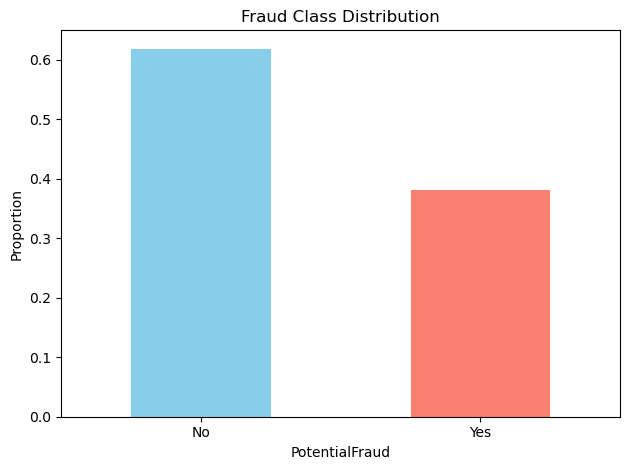

In [237]:
# Phase 2 - Step 1: Visualize class imbalance in fraud labels
import matplotlib.pyplot as plt

# Calculate proportion of fraud vs. non-fraud cases
fraud_counts = train_full['PotentialFraud'].value_counts(normalize=True)
print("Fraud Class Distribution (Proportions):")
print(fraud_counts)

# Bar plot to show imbalance
fraud_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Fraud Class Distribution")
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

      Provider  TotalReimbursement
818   PRV52019             5996050
3557  PRV55462             4713830
4446  PRV56560             3212000
2705  PRV54367             3133880
3000  PRV54742             2969530
3358  PRV55209             2914700
2176  PRV53706             2831940
4334  PRV56416             2744870
3373  PRV55230             2612740
1071  PRV52340             2540130


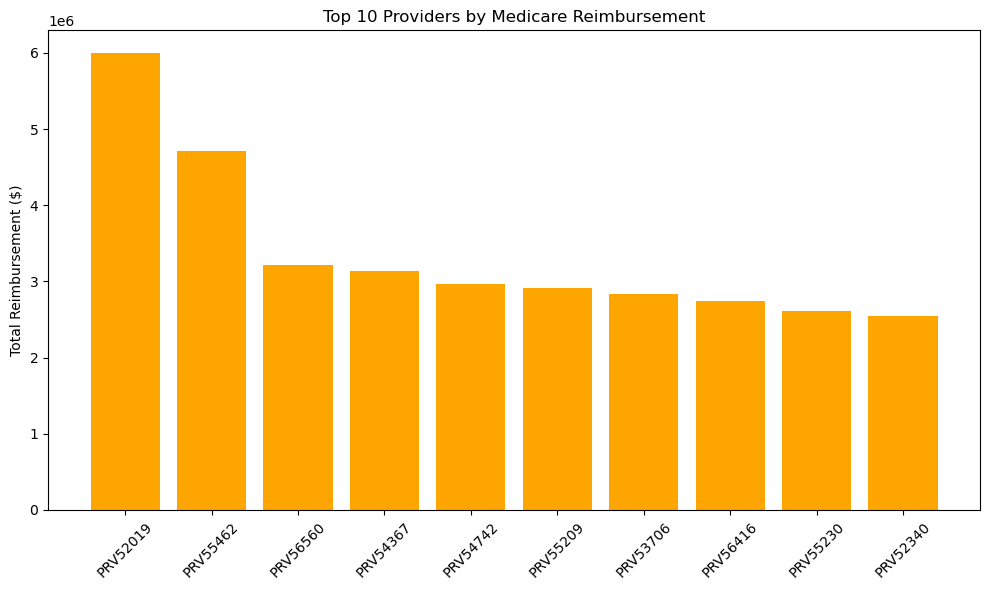

In [238]:
# Phase 2 - Step 2: Identify providers with highest total Medicare reimbursements
# Sum reimbursement amount per provider
reimb_per_provider = train_full.groupby('Provider')['InscClaimAmtReimbursed'].sum().reset_index()
reimb_per_provider.columns = ['Provider', 'TotalReimbursement']

# Get top 10 providers by total reimbursement
top_reimb = reimb_per_provider.sort_values(by='TotalReimbursement', ascending=False).head(10)
print(top_reimb)

# Plot top 10 reimbursed providers
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(top_reimb['Provider'], top_reimb['TotalReimbursement'], color='orange')
plt.xticks(rotation=45)
plt.ylabel("Total Reimbursement ($)")
plt.title("Top 10 Providers by Medicare Reimbursement")
plt.tight_layout()
plt.show()

      Provider  InpatientClaimCount  OutpatientClaimCount  TotalClaims
363   PRV51459                  0.0                8240.0       8240.0
2250  PRV53797                  0.0                4739.0       4739.0
455   PRV51574                  0.0                4444.0       4444.0
2335  PRV53918                  0.0                3588.0       3588.0
3113  PRV54895                  3.0                3433.0       3436.0
3363  PRV55215                143.0                3250.0       3393.0
853   PRV52064                 38.0                2806.0       2844.0
4004  PRV56011                  0.0                2833.0       2833.0
3195  PRV55004                  3.0                2396.0       2399.0
5032  PRV57306                  0.0                2315.0       2315.0


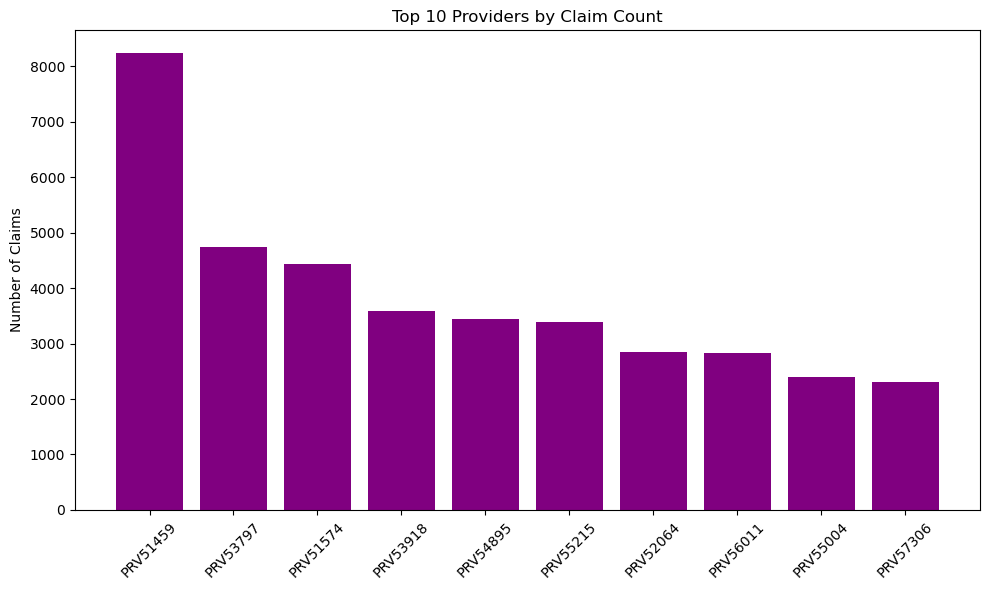

In [239]:
#Phase 2 - Step 3: Analyze claim volume per provider

# Count inpatient claims per provider
inpatient_counts = train_inpatient['Provider'].value_counts().reset_index()
inpatient_counts.columns = ['Provider', 'InpatientClaimCount']

# Count outpatient claims per provider
outpatient_counts = train_outpatient['Provider'].value_counts().reset_index()
outpatient_counts.columns = ['Provider', 'OutpatientClaimCount']

# Merge inpatient and outpatient counts
claim_counts = pd.merge(inpatient_counts, outpatient_counts, on='Provider', how='outer').fillna(0)

# Compute total claims per provider
claim_counts['TotalClaims'] = claim_counts['InpatientClaimCount'] + claim_counts['OutpatientClaimCount']

# Display top 10 providers by number of claims
top_claims = claim_counts.sort_values(by='TotalClaims', ascending=False).head(10)
print(top_claims)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(top_claims['Provider'], top_claims['TotalClaims'], color='purple')
plt.xticks(rotation=45)
plt.ylabel("Number of Claims")
plt.title("Top 10 Providers by Claim Count")
plt.tight_layout()
plt.show()

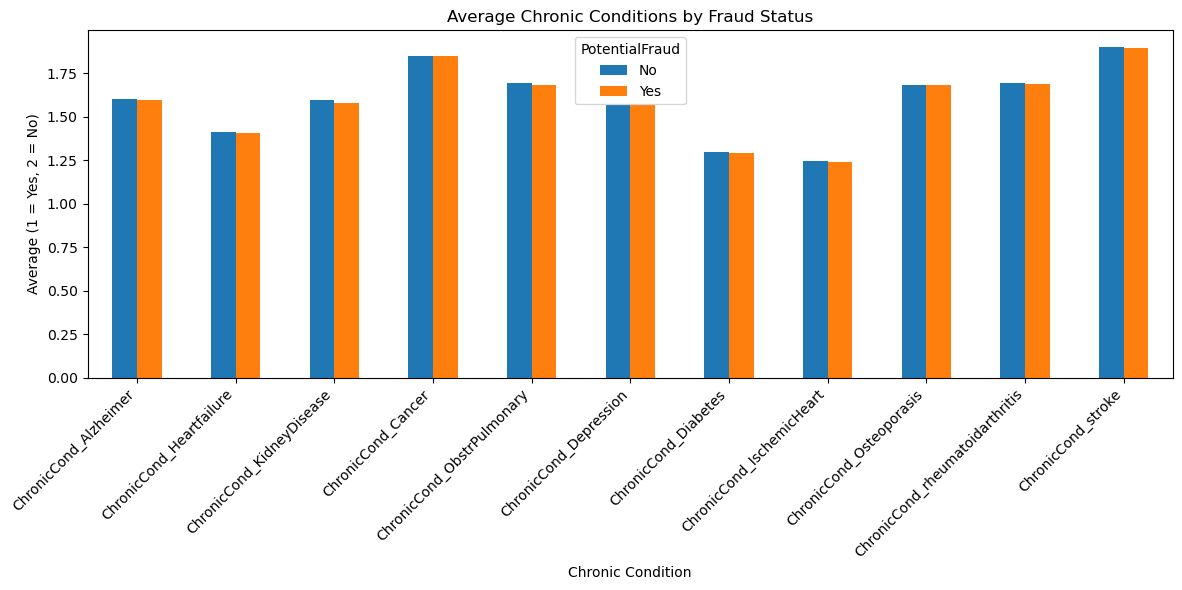

In [240]:
#Phase 5 - Step 4: Compare chronic condition prevalence between fraudulent and non-fraudulent providers
# Define chronic condition columns
chronic_cols = [
    "ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease",
    "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression",
    "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis",
    "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke"
]

# Compute average value per condition grouped by fraud label
chronic_means = train_full.groupby("PotentialFraud")[chronic_cols].mean()

# Transpose for visualization
plot_data = chronic_means.T

# Plot chronic condition patterns
import matplotlib.pyplot as plt
plot_data.plot(kind='bar', figsize=(12, 6))
plt.title("Average Chronic Conditions by Fraud Status")
plt.xlabel("Chronic Condition")
plt.ylabel("Average (1 = Yes, 2 = No)")
plt.xticks(rotation=45, ha='right')
plt.legend(title='PotentialFraud')
plt.tight_layout()
plt.show()

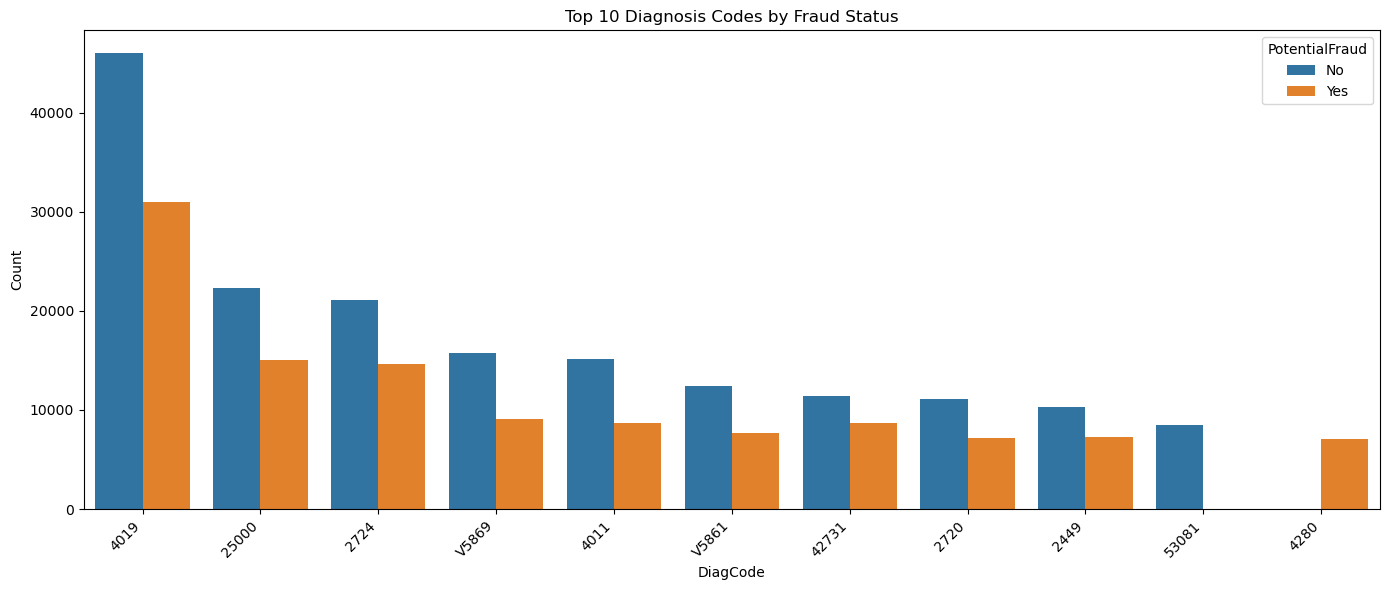

In [241]:
#Phase 2 - Step 5: Examine most common diagnosis codes by fraud status
import seaborn as sns
import matplotlib.pyplot as plt

# Collect all diagnosis code columns
diag_cols = [col for col in train_full.columns if col.startswith("ClmDiagnosisCode")]
diagnosis_data = train_full[diag_cols + ['PotentialFraud']].copy()

# Melt into long format to count code occurrences
diagnosis_melted = diagnosis_data.melt(
    id_vars='PotentialFraud',
    value_vars=diag_cols,
    var_name='DiagCodeType',
    value_name='DiagCode'
).dropna()

# Count top diagnosis codes by fraud status
top_codes = (
    diagnosis_melted.groupby(['PotentialFraud', 'DiagCode'])
    .size()
    .reset_index(name='Count')
    .sort_values(['PotentialFraud', 'Count'], ascending=[True, False])
)

# Take top 10 for each group
top_10_codes = top_codes.groupby('PotentialFraud').head(10)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=top_10_codes, x='DiagCode', y='Count', hue='PotentialFraud')
plt.title("Top 10 Diagnosis Codes by Fraud Status")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Feature Engineering

In [243]:
# Assume reference date for age calculation
reference_date = pd.to_datetime('2009-12-31')

# 1. Convert DOB and calculate age
train_full['DOB'] = pd.to_datetime(train_full['DOB'], errors='coerce')
train_full['Age'] = (reference_date - train_full['DOB']).dt.days // 365

# 2. RenalDiseaseIndicator: 'Y' -> 1, others -> 0
train_full['RenalDiseaseIndicator'] = train_full['RenalDiseaseIndicator'].map({'Y': 1}).fillna(0).astype(int)

# 3. Create Num_ChronicCond_2 and drop ChronicCond_* columns
chronic_cols = [col for col in train_full.columns if col.startswith('ChronicCond_')]
train_full['Num_ChronicCond_2'] = train_full[chronic_cols].apply(lambda row: (row == 2).sum(), axis=1)
train_full.drop(columns=chronic_cols, inplace=True)

# 4. Source mapping
train_full['Source'] = train_full['Source'].map({'Inpatient': 1, 'Outpatient': 2})

# 5. ReimbursedRatio
train_full["TotalClaimAmt"] = train_full["InscClaimAmtReimbursed"] + train_full["DeductibleAmtPaid"]
train_full["ReimbursedRatio"] = np.where(
    train_full["TotalClaimAmt"] == 0,
    0,
    train_full["InscClaimAmtReimbursed"] / train_full["TotalClaimAmt"]
)

# 6. Claim duration
train_full["ClaimStartDt"] = pd.to_datetime(train_full["ClaimStartDt"], errors='coerce')
train_full["ClaimEndDt"] = pd.to_datetime(train_full["ClaimEndDt"], errors='coerce')
train_full["ClaimDuration"] = (train_full["ClaimEndDt"] - train_full["ClaimStartDt"]).dt.days

# 7. Diagnosis and procedure code count
diag_cols = [col for col in train_full.columns if col.startswith("ClmDiagnosisCode")]
proc_cols = [col for col in train_full.columns if col.startswith("ClmProcedureCode")]
train_full["num_diagnosis_codes"] = train_full[diag_cols].notna().sum(axis=1)
train_full["num_procedure_codes"] = train_full[proc_cols].notna().sum(axis=1)

# 8. Drop all unnecessary columns at once
drop_cols = [
    'BeneID', 'ClaimID', 'DOB', 'DOD', 'County',
    'AttendingPhysician', 'OperatingPhysician', 'OtherPhysician', 'Provider',
    'AdmissionDt', 'DischargeDt', 'ClaimStartDt', 'ClaimEndDt',
    'ClmAdmitDiagnosisCode'
] + diag_cols + proc_cols

train_full.drop(columns=drop_cols, inplace=True, errors='ignore')

# 9. Drop single-value columns
single_val_cols = [col for col in train_full.columns if train_full[col].nunique() <= 1]
train_full.drop(columns=single_val_cols, inplace=True)

# 10. Drop high-missing-value columns (>90%)
high_missing_cols = train_full.columns[train_full.isnull().mean() > 0.9]
train_full.drop(columns=high_missing_cols, inplace=True)

# 11. Separate features and label
X = train_full.drop(columns=['PotentialFraud'], errors='ignore')
y = train_full['PotentialFraud'].map({'No': 0, 'Yes': 1})


In [244]:
# Filling the missing value with Mode
for col in X.columns:
    mode_val = X[col].mode(dropna=True)
    if not mode_val.empty:
        X[col] = X[col].fillna(mode_val[0])

# Confirm final feature matrix shape
with pd.option_context('display.max_columns', None, 'display.width', None):
    print("Cleaned feature matrix shape:", X.shape)
    print("Target vector shape:", y.shape)
    display(X.head())

Cleaned feature matrix shape: (558211, 20)
Target vector shape: (558211,)


,InscClaimAmtReimbursed,DeductibleAmtPaid,Source,Gender,Race,RenalDiseaseIndicator,State,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,Age,Num_ChronicCond_2,TotalClaimAmt,ReimbursedRatio,ClaimDuration,num_diagnosis_codes,num_procedure_codes
0,26000,1068.0,1,1,1,0,39,12,12,36000,3204,60,70,67,4,27068.0,0.960544,6,9,0
1,5000,1068.0,1,1,1,0,39,12,12,36000,3204,60,70,67,4,6068.0,0.823995,2,3,1
2,5000,1068.0,1,1,1,0,39,12,12,36000,3204,60,70,67,4,6068.0,0.823995,3,6,0
3,5000,1068.0,1,2,2,0,1,12,12,5000,1068,250,320,95,5,6068.0,0.823995,8,9,1
4,10000,1068.0,1,2,1,1,45,12,12,21260,2136,120,100,71,6,11068.0,0.903506,17,9,1


### SMOTE-balanced XGBoost

In [267]:
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

# 1. Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# 2. Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Original training class distribution:", y_train.value_counts().to_dict())
print("After SMOTE class distribution:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# 3. Train an XGBoost classifier
model = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_resampled, y_resampled)

# 4. Predict on the validation set
y_pred = model.predict(X_val)

# 5. Evaluate model performance
print("Classification Report:\n", classification_report(y_val, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Training set shape: (446568, 20)
Validation set shape: (111643, 20)
Original training class distribution: {0: 276332, 1: 170236}
After SMOTE class distribution: {0: 276332, 1: 276332}
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.70      0.70     69083
           1       0.52      0.52      0.52     42560

    accuracy                           0.63    111643
   macro avg       0.61      0.61      0.61    111643
weighted avg       0.63      0.63      0.63    111643

Confusion Matrix:
 [[48490 20593]
 [20264 22296]]


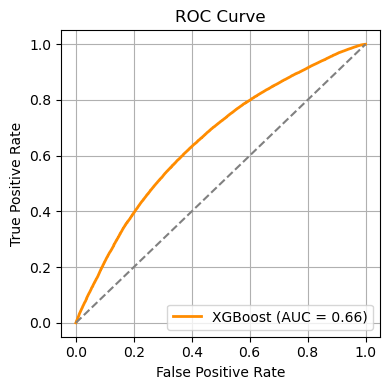

In [247]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predict probability scores instead of hard labels
y_probs = model.predict_proba(X_val)[:, 1]  # probability of class 1

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_probs)
auc_score = roc_auc_score(y_val, y_probs)

# Plot the ROC curve
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f"XGBoost (AUC = {auc_score:.2f})", color='darkorange', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


### RandomForest

In [249]:
# Train Random Forest on SMOTE data
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_resampled, y_resampled)

# Predict on validation set
rf_probs = rf_model.predict_proba(X_val)[:, 1]
rf_preds = rf_model.predict(X_val)

# Evaluation
print("Random Forest - Classification Report")
print(classification_report(y_val, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, rf_preds))
print("AUC Score:", roc_auc_score(y_val, rf_probs))


Random Forest - Classification Report
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     69083
           1       0.45      0.44      0.44     42560

    accuracy                           0.58    111643
   macro avg       0.56      0.56      0.56    111643
weighted avg       0.58      0.58      0.58    111643

Confusion Matrix:
 [[46655 22428]
 [24020 18540]]
AUC Score: 0.5886774127278411


### LogisticRegression

In [271]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

# Train Logistic Regression on SMOTE data
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_resampled, y_resampled)

# Predict on validation set
lr_probs = lr_model.predict_proba(X_val)[:, 1]
lr_preds = lr_model.predict(X_val)

# Evaluation
print("Logistic Regression - Classification Report")
print(classification_report(y_val, lr_preds))
print("Confusion Matrix:\n", confusion_matrix(y_val, lr_preds))
print("AUC Score:", roc_auc_score(y_val, lr_probs))


Logistic Regression - Classification Report
              precision    recall  f1-score   support

           0       0.64      0.62      0.63     69083
           1       0.41      0.43      0.42     42560

    accuracy                           0.55    111643
   macro avg       0.53      0.53      0.53    111643
weighted avg       0.55      0.55      0.55    111643

Confusion Matrix:
 [[42857 26226]
 [24095 18465]]
AUC Score: 0.5407500278691133


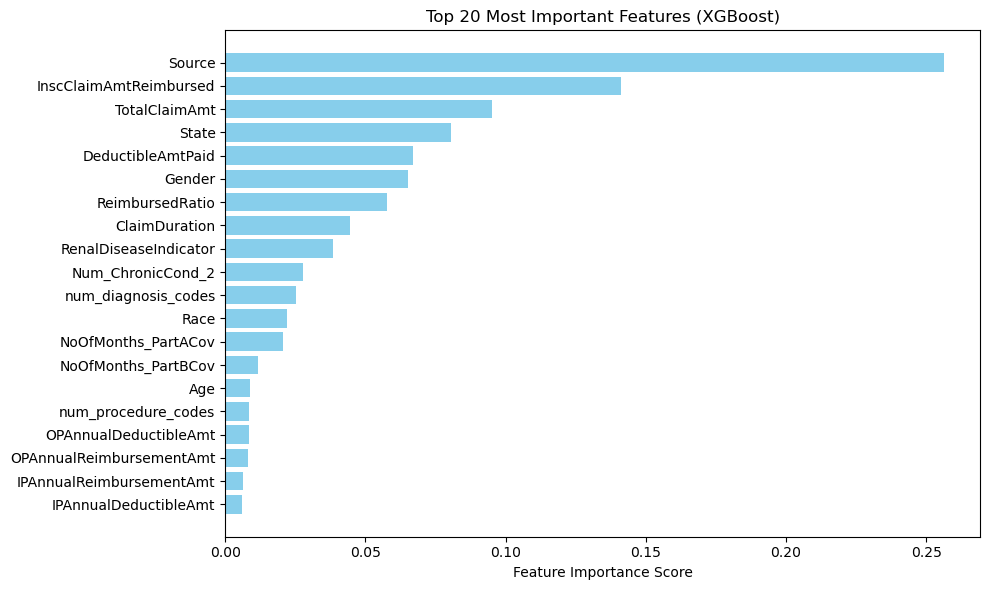

In [252]:
# Get feature importance scores
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easier handling
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and take top 20
top_feats = feat_imp_df.sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_feats['Feature'][::-1], top_feats['Importance'][::-1], color='skyblue')
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()
